In [71]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from model import define_tables
from pydal import DAL

In [15]:
batch_size = 64
img_height = 224
img_width = 224
image_size = (img_width, img_height)
validation_split = 0.33
data_dir = "data/images_is_flower/train"
num_classes = 1

In [16]:
def get_dataset_from_directory(type, seed=123):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=type,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

train_ds = get_dataset_from_directory("training")
val_ds = get_dataset_from_directory("validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 831 files belonging to 2 classes.
Using 557 files for training.
Found 831 files belonging to 2 classes.
Using 274 files for validation.


In [17]:
type( train_ds )

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [18]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


In [19]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [20]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/5
9/9 [==============================] - 49s 3s/step - loss: 0.5857 - binary_accuracy: 0.6884 - val_loss: 0.4330 - val_binary_accuracy: 0.8139
Epoch 2/5
9/9 [==============================] - 14s 2s/step - loss: 0.4779 - binary_accuracy: 0.7712 - val_loss: 0.4019 - val_binary_accuracy: 0.8358
Epoch 3/5
9/9 [==============================] - 14s 2s/step - loss: 0.4675 - binary_accuracy: 0.7881 - val_loss: 0.3759 - val_binary_accuracy: 0.8175
Epoch 4/5
9/9 [==============================] - 14s 2s/step - loss: 0.3338 - binary_accuracy: 0.8461 - val_loss: 0.3728 - val_binary_accuracy: 0.8394
Epoch 5/5
9/9 [==============================] - 14s 2s/step - loss: 0.4055 - binary_accuracy: 0.8497 - val_loss: 0.3802 - val_binary_accuracy: 0.8431


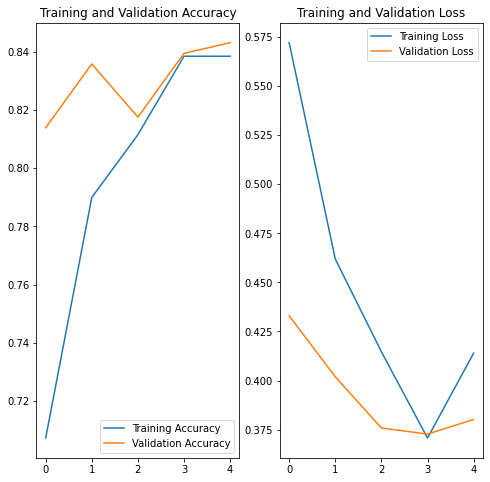

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
img_filenames = glob(data_dir + '/0/*')
img_filenames += glob(data_dir + '/1/*')
images = []
for image in img_filenames:
    img = keras.preprocessing.image.load_img(
        image, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    images.append(img_array)

images = np.vstack(images)
predictions = model.predict(images)
score = predictions


In [72]:
db = DAL('sqlite://flower_storage.db', folder='./data')
define_tables(db)

file_id_re = re.compile(".*[/\\\\]([0-9]+)\.[A-Za-z0-9]*$")
ids_and_is_non_flowers_pred = zip(
    [int(file_id_re.match(name)[1]) for name in img_filenames], list(score[:, 0] > 0.5)
)
for img_id, is_non_flower_pred in ids_and_is_non_flowers_pred:
    db( db.images.id == img_id ).update(is_non_flower_model_prediction=is_non_flower_pred)

db.commit()

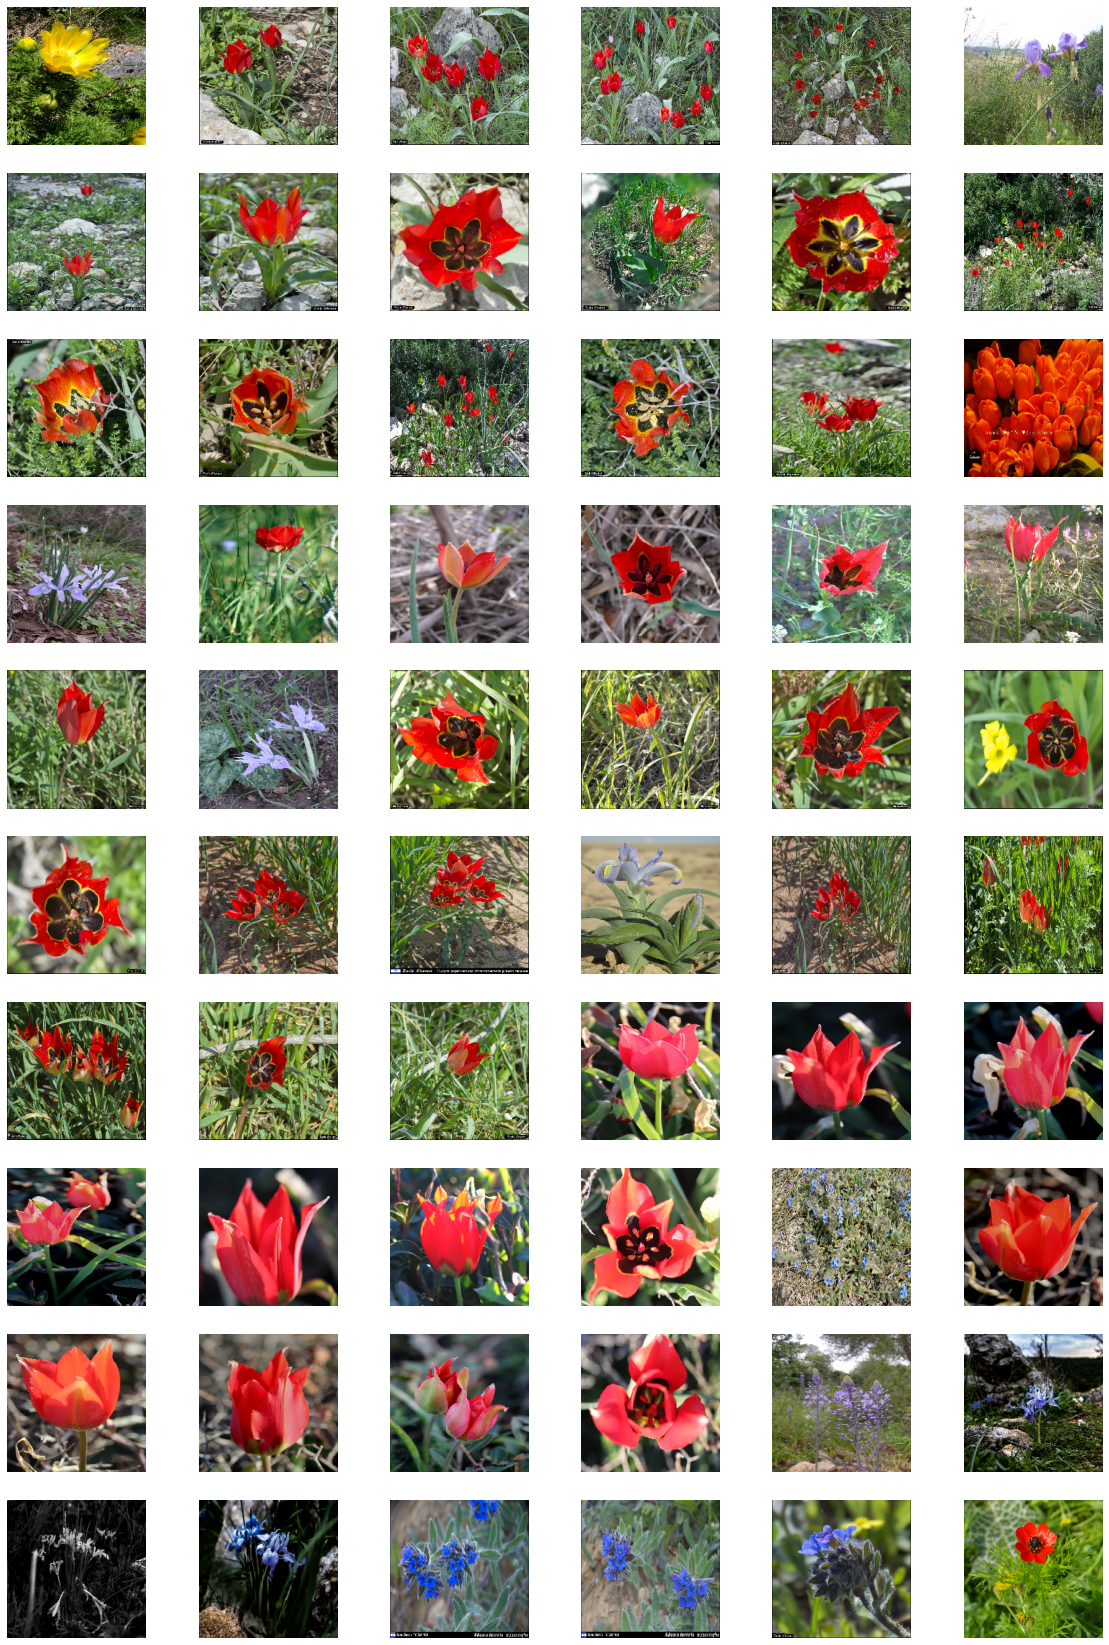

In [28]:
plt.figure(figsize=(20, 30))
for i,image in enumerate(images[0:60]):
    ax = plt.subplot(10, 6, i + 1)
    image = (tf.expand_dims(image, 0))
    plt.imshow(image[0] / 255)
    plt.axis('off')